## Attention

- 어텐션 메커니즘은 모델로 하여금 '중요한 부분만 집중하게 만들자'가 핵심 아이디어.
- 하나의 고정된 길이의 컨텍스트 벡터로 인코딩 하는 대신 출력의 각 단계별로 컨텍스트 벡터를 생성하는 방법을 학습한다.
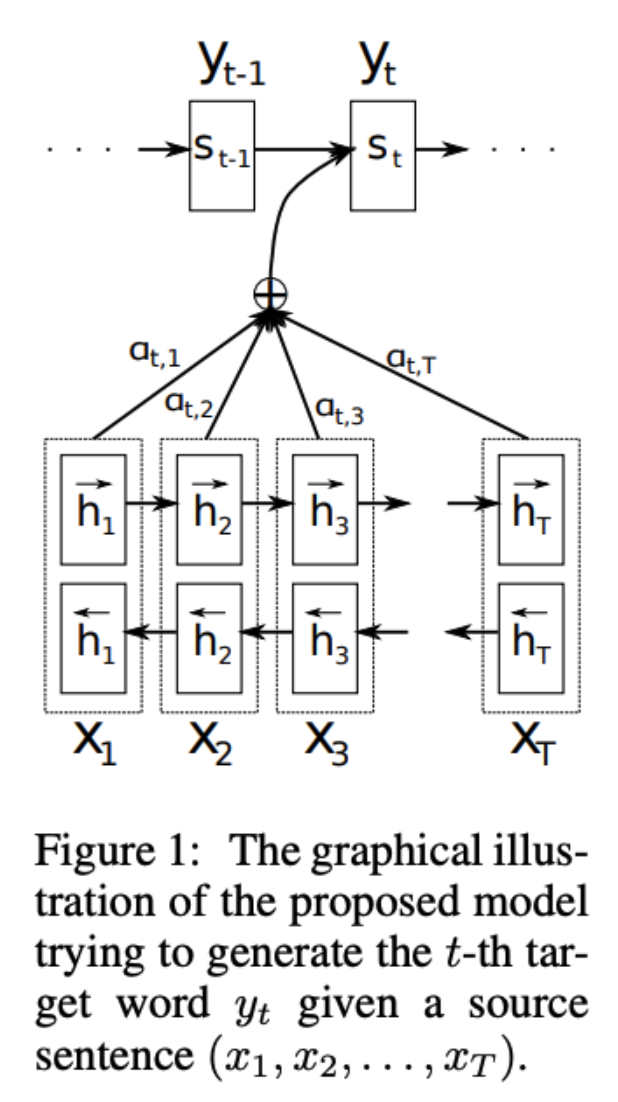

- 위 NMT 모델에서 y는 디코더가 생성한 번역 결과, x는 입력 문장이며 양방향 bidirectional RNN 모델
- 출력 단어 $y_t$가 마지막 상태 뿐만 아니라 입력 상태의 모든 조합을 참조하고 있다는 점이며, 여기서 α는 각 출력이 어떤 입력 상태를 더 많이 참조하는지에 대한 가중치로, α의 합은 1로 normalized 된. 즉, softmax 값을 사용

- 생성을 하는 디코더에 BOS, 제너레이터에 EOS가 포함된다.


- 트랜스포머의 입력 : 트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩이라고 한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('/Users/hoyoung/Desktop/pycharm_work/korean_grammar_corrector')
import utils.tensorflow_preprocess as tp

In [2]:
def get_angles(pos, i, d_model):
    '''
    pos : 입력 문장에서의 임베딩 벡터의 위치
    i : 임베딩 벡터 내의 차원의 인덱스
    d_model : 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의 하이퍼파라미터
    
    Positional Embedding 의 pos / 10000 ** (2i / d_model) 부분 산출 함수

    PE(pos, 2i) = sin(pos / 10000 ** (2i / d_model))     ((pos, 2i)일때 sin함수))
    PE(pos, 2i + 1) = cos(pos / 10000 ** (2i / d_model)) ((pos, 2i+1일때 cos함수))
    '''
    angle_rates = 1 / np.power(10000, (2 * i // 2) / np.float32(d_model))
    # shape = (1, d_model)
    # pos shape :
    # angle_rates shape = (1, d_model)
    # return shape = 행렬곱 (pos, 1), (1, d_model) =  (pos, d_model)
    return np.matmul(pos, angle_rates)

In [3]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)  # shape : (position, d_model)
    # 오른쪽으로 짝수번째 인덱스는 sin 함수를 적용
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # 오른쪽으로 홀수번째 인덱스는 cos 함수를 적용
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]  # pos_encoding shape : (1, position, d_model)
    # 왜 shape에 1을 추가해주냐면, batch_size 만큼 학습하기 위함임

    return tf.cast(pos_encoding, dtype=tf.float32)


In [4]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    '''
    포지셔널 인코딩 방법을 사용하면 순서 정보가 보존되는데, 예를 들어 각 임베딩 벡터에 포지셔널 인코딩의 값을 더하면
    같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의 입력으로 들어가는 임베딩 벡터의 값이 달라진다.
    이에 따라 트랜스포머의 입력은 순서 정보가 고려된 임베딩 벡터가 된다.
    
    position : 입력 문장에서의 임베딩 벡터의 위치
    i : 임베딩 벡터 내의 차원의 인덱스
    d_model : 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의 하이퍼파라미터
    
    Positional Embedding 의 position / 10000 ** (2i / d_model) 부분 산출 함수

    PE(position, 2i) = sin(position / 10000 ** (2i / d_model))     ((pos, 2i)일때 sin함수))
    PE(position, 2i + 1) = cos(position / 10000 ** (2i / d_model)) ((pos, 2i+1일때 cos함수))
    
    shape = (1, d_model)
    angle_rates shape = (1, d_model)
    return shape = 행렬곱 (position, 1), (1, d_model) =  (position, d_model)
    '''
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    def get_angles(self, position, i, d_model):

        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
        position= tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)# shape : (position, d_model)
        # 오른쪽으로 짝수번째 인덱스는 sin 함수를 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 오른쪽으로 홀수번째 인덱스는 cos 함수를 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]  # pos_encoding shape : (1, position, d_model)

        return tf.cast(pos_encoding, dtype=tf.float32)

    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


2022-11-11 16:32:20.467563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


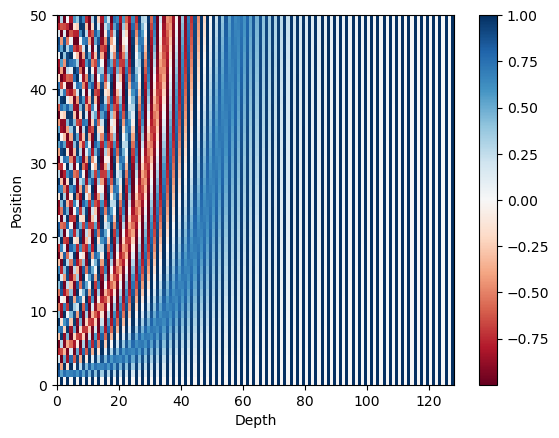

In [5]:
# 50 * 128의 크기를 가지는 포지셔널 인코딩 행렬 시각화 -> 입력 문장의 단어가 50개이면서, 각 단어가 128차원의 임베딩 벡터를 가질때의 행렬

sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### 트랜스포머에 사용되는 세가지의 어텐션
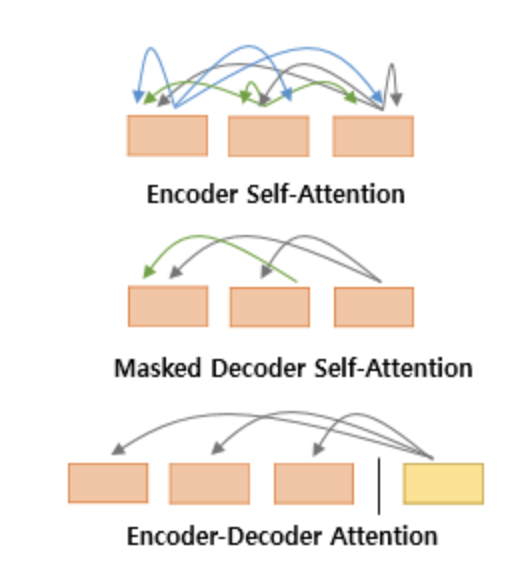

    - 셀프 어텐션은 본질적으로 Query, Key, Value 가 동일한 경우를 말함.
        - Q: Vector(Linear layer output) related with what we encode(output, it can be output of encoder layer or decoder layer)
        - K: Vector(Linear layer output) related with what we use as input to output.
        - V: Learned vector(Linear layer output) as a result of calculations, related with input
       
    - 세번째의 인코더-디코더 어텐션은 Query가 디코더의 벡터인 반면, key와 value가 인코더의 벡터이므로 셀프어텐션이라고 부르지 않는다.
        
        **주의 : 여기서 Query, Key등이 같다는것은 벡터의 값이 아닌 벡터의 출처가 같다는 의미.**
    
    
        1- Encoder Self attention
            Q = K = V = Our source sentence

        2- Decoder Self attention
            Q = K = V = Our target sentence

        3- Decoder-Encoder attention
            Q = Our target sentence
            K = V = Our source sentence
    
    ```
    인코더의 셀프 어텐션 : Query = Key = Value
    디코더의 마스크드 셀프 어텐션 : Query = Key = Value
    디코더의 인코더-디코더 어텐션 : Query : 디코더 벡터 / Key = Value : 인코더 벡터
    ```
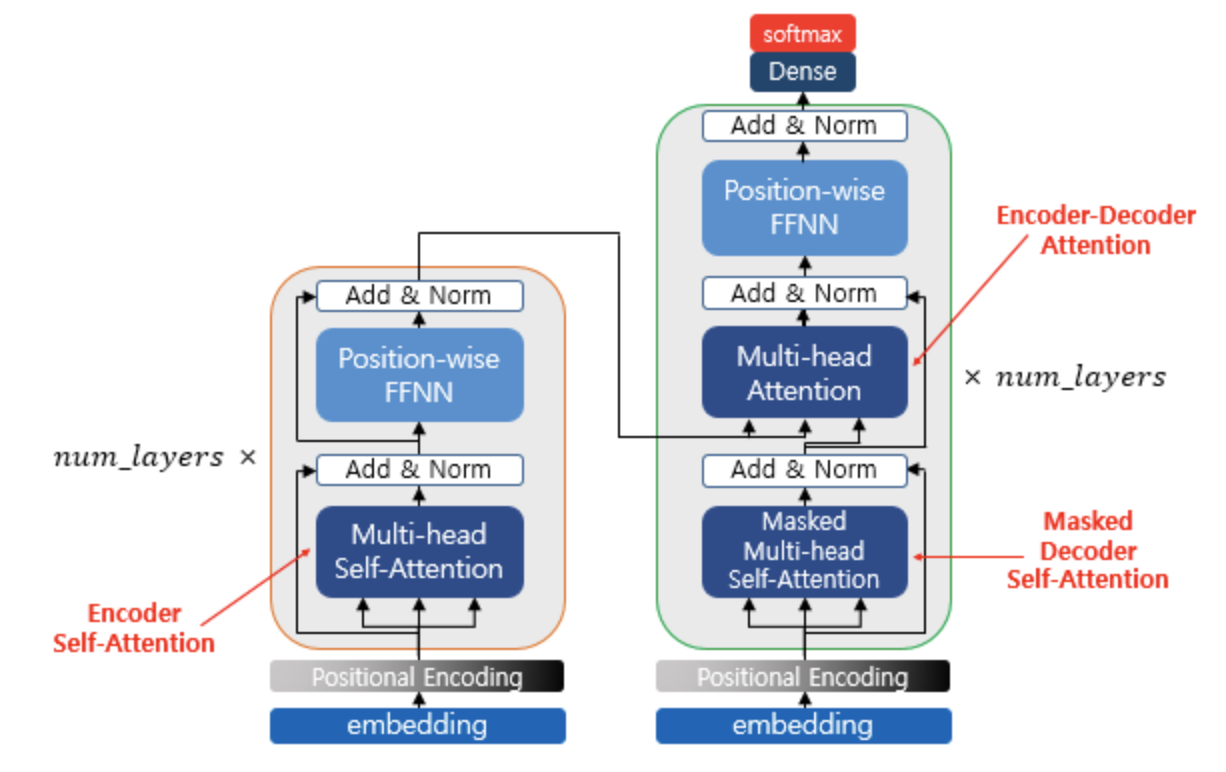

**Multi-head: 트랜스포머가 병렬적으로 수행하는 방법을 의미함**


    - 인코더를 하나의 층이라고 했을때 하나의 인코더 층은 크게 총 2개의 서브층으로 나누어진다.
        1. Self Attention (그림상 Multi self attention)
        2. Feed Forward(그림상 position-wise feed forward)
       

### Self-Attention
**Attention 함수는 주어진 쿼리에 대해서 모든 키와의 유사도를 각각 구한다. 그리고 구해낸 유사도를 가중치로 하여 키와 맵핑 되어있는 각각의 값에 반영하며 유사도가 반영된 값을 모두 가중합하여 리턴한다.**
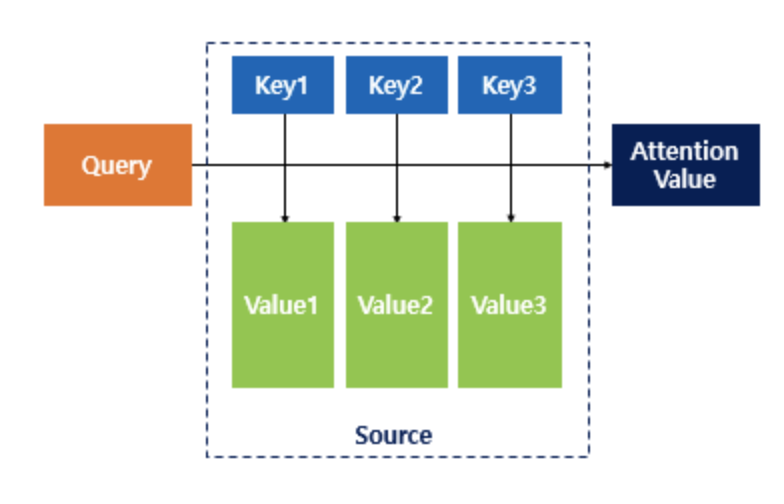


1. Q, K, V 벡터 얻기
    - 각 단어 벡터들로 부터 Q, K, V벡터를 얻는 작업을 거친다.
    - Q, K, V는 초기 입력인 d_model의 차원보다 더 작은 차원을 가지는데 이는 하이퍼파라미터인 num_heads로 결정됨
        - 기존의 벡터로 부터 더작은 벡터는 가중치 행렬을 곱하므로서 완성된다.
        - 각 가중치 행렬은 $d_{model}*(d_{model}/num_{heads})$의 크기를 가진다.
        - 예를 들어, d_model=512이고 num_heads=8이라면 각 벡터에 3개의 서로 다른 가중치행렬을 곱하고 64의 크기를 가지는 Q, K, V 벡터를 얻는다.


2. Scaled dot-product Attention
    - 각 Q벡터는 모든 K벡터에 대해서 어텐션 스코어를 구하고, 어텐션 분포를 구한 뒤에 이를 사용하여 모든 V벡터를 가중합 하여 어텐션 값 또는 컨텍스트 벡터를 구하게 된다. 그리고 이를 모든 Q벡터에 대해서 반복한다.
        - Scaled dot-product Attention : $score(q,k) = \frac{q*k} {\sqrt{n}}$ (dot-product Attention에서 값을 스케일링하는것을 추가한 값)를 통해 각 단어에 대한 어텐션 스코어를 구한다.
        - 구한 어텐션 스코어에 소프트맥스 함수를 사용하여 어텐션 분포를 구하고 각 V벡터와 가중합하여 어텐션 값을 구한다.


3. 행렬 연산으로 일괄 처리.
    - 위의 Scaled dot-product Attention 연산은 행렬 연산으로 구현한다.
    
    - 각 단어 벡터마다 일일히 가중치 행렬을 곱하는것이 아닌 문장 행렬에 가중치 행렬을 곱하여 Q, K, V 행렬을 구한다.
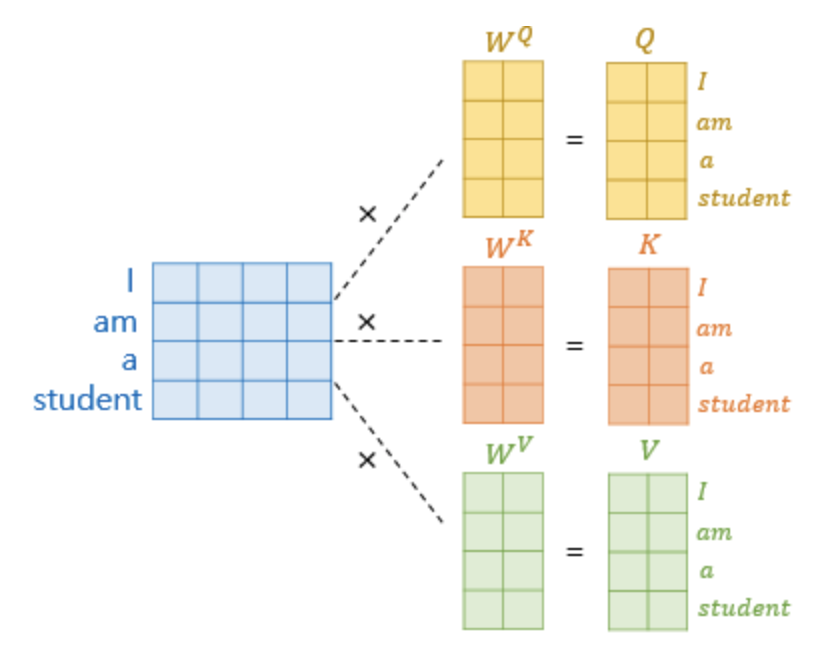
    
        - Q행렬을 K행렬을 전치한 행렬과 곱해주면 각각의 단어의 Q벡터와 K벡터의 내적이 각 행렬의 원소가 되는 행렬이 결과로 나온다.
        - 결과 행렬의 값에 전체적으로 $\sqrt{d_k}$ 를 나누어주면 각 행과 열이 어텐션 스코어 값을 가지는 행렬이 된다. ($d_k :$ Key의 차원)
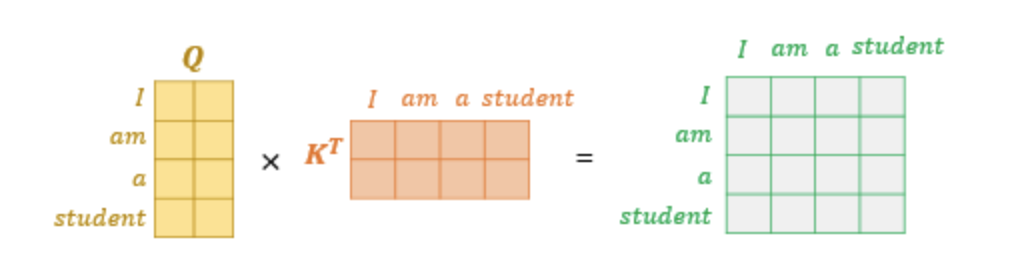

        - 위의 어텐션 스코어 행렬에 소프트맥스 함수를 사용하고 V행렬을 곱하면 어텐션 값(Attention Value)행렬이 결과로 나온다.
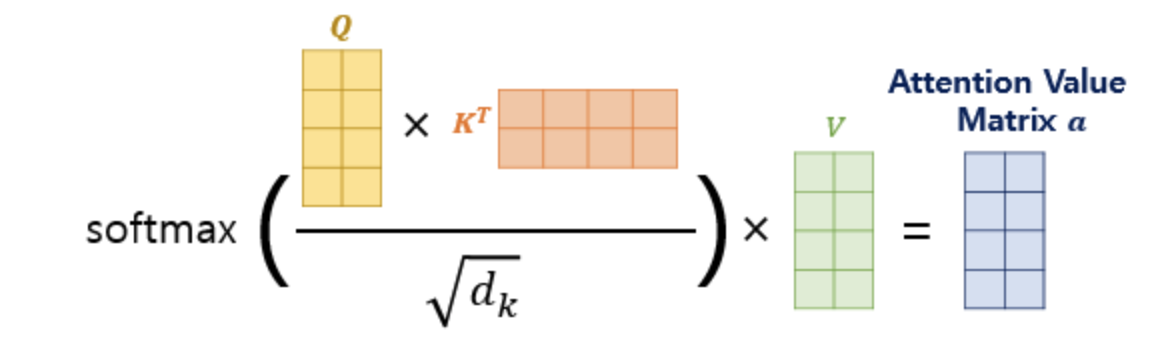

$$Attention(Q,K,V)= softmax(\frac{QK^T}{\sqrt{d_k}})V $$
    

### Self-Attention  단계 요약

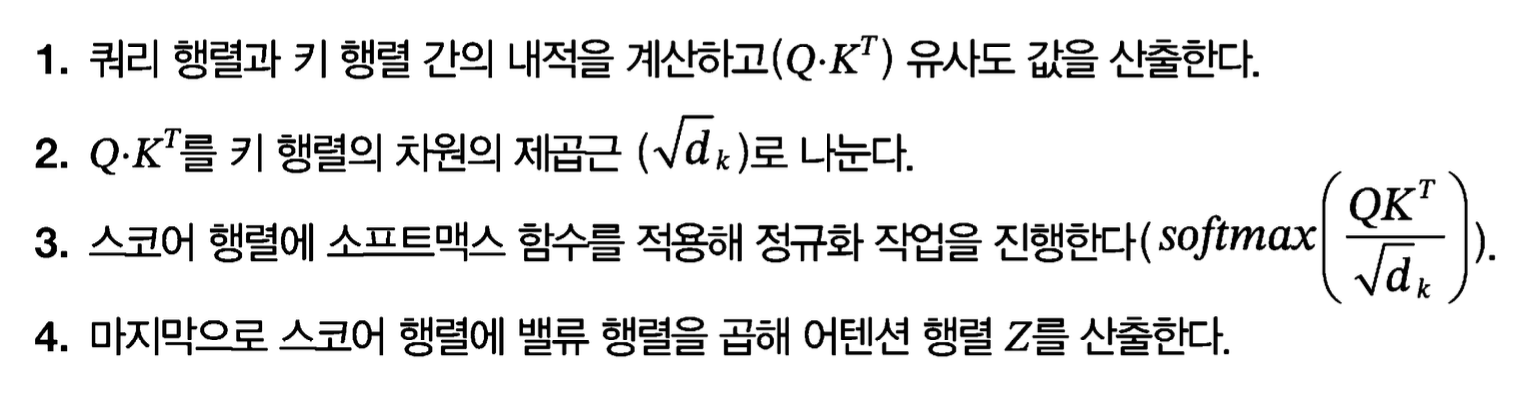



In [6]:
def scaled_dot_product_attention(q, k, v, mask=None):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)
    
    # Q와 K의 곱. Attention Score 행렬.
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    # scaling
    # d_k의 루트값으로 나눠준다.
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # Masking : 어텐션에서 제외하기 위해 값을 가려준다는 의미이며 트랜스포머에 존재하는 <PAD> 토큰에 대한 유사도를 구하지 않기 위해 시행
    # 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값으로 소프트맥스 함수를 자나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 k의 문장 길이 방향으로 수행된다.
    # attention weight shape : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)

    # output(attention_value) shape : (batch_size, seq_len, d_model/num_heads)
    # 즉 처음 입력 차원인 (batch_size, seq_len, d_model/num_heads) 차원을 아웃풋으로 반환
    # 인풋과 아웃풋의 사이즈가 동일하다.

    # scaled_dot_product_attention 의 결과는 단어들 간의 연관성을 학습.
    return output, attention_weights

##### scaled_dot_product_attention 예제

In [7]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성하여 이를 scaled_dot_product_attention 함수에 입력으로 넣어 함수가 리턴하는 값을 출력.
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

In [8]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

# Q의 값이 K의 값중 2번째 값과 일치하므로 어텐션 분포는 [0,1,0,0]의 값을 가지며 결과적으로 Vlaue의 두번째 값인 [10,0]이 출력 된다.

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [9]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [10]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### Multi-head Attention

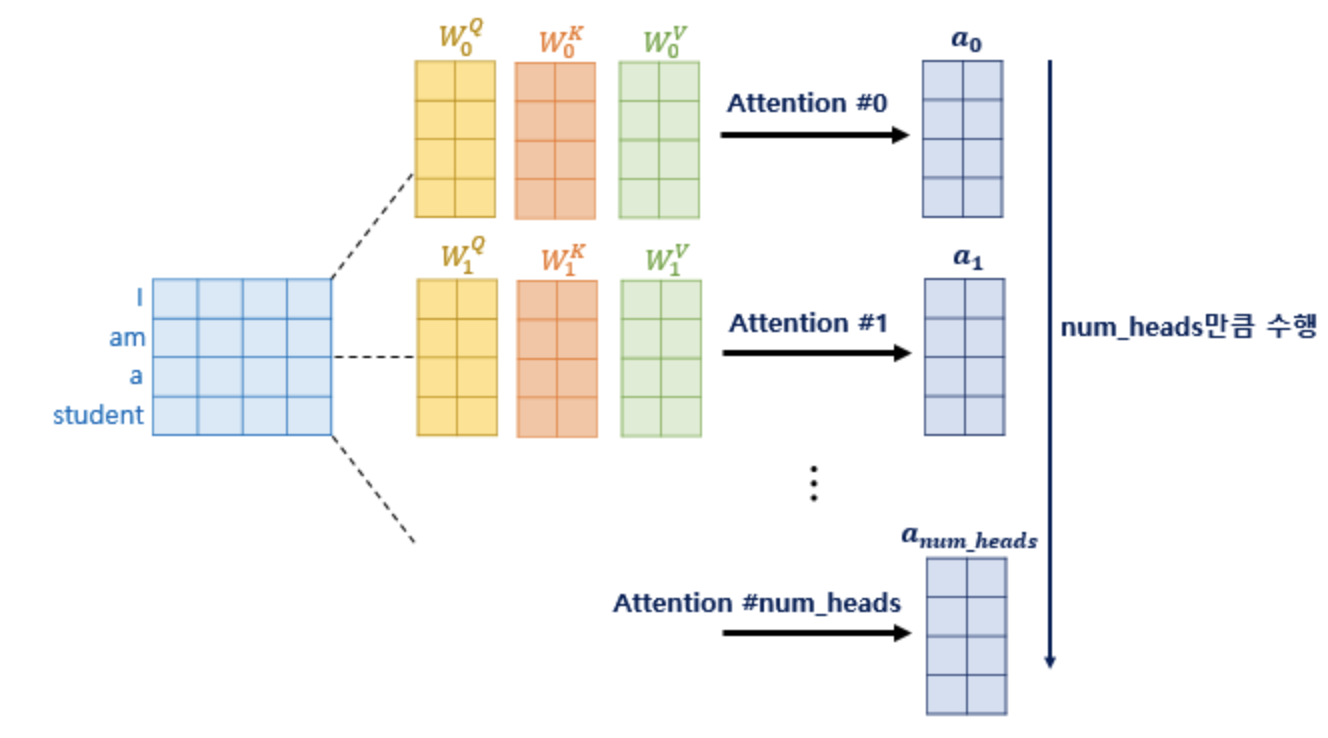

    - 예를 들어 num_heads=8일때, 어텐션이 8개의 병렬로 이루어지는데, 이때 각각의 어텐션 값 행렬을 어텐션 헤드라 한다.
    - 어텐션 헤드마다 가중치 행렬의 값이 모두 다르다.
    - 병렬 어텐션을 모두 수행한뒤 모든 어텐션 헤드를 연결(concatenate)한다. -> shape : (seq_len, d_model)
    - 모두 연결한 행렬과 또 다른 가중치 행렬 $W^o$를 곱해주어 나온 결과 행렬이 멀티-헤드 어텐션의 최종 결과이다.
    - 아래의 그림은 어텐션 헤드를 모두 연결한 행렬이 가중치 행렬 $W^o$과 곱해지는 과정.
        - $W^o$을 곱해주는 이유: 어텐션 헤드를 N개를 연결하면 크기가 어텐션 헤드 * N가 되므로 크기를 줄이기 위해 (어텐션 헤드의 최종 결과는 어텐션 헤드의 원래 크기.)
    - 이때 결과물인 멀티-헤드 어텐션 행렬은 인코더의 입력이였던 문장 행렬의 (seq_len, d_model)의 크기와 동일하다.
    -  첫번째 서브층인 멀티-헤드 어텐션과 두번째 서브층인 포지션 와이즈 피드 포워드 신경망을 지나면서 인코더의 입력으로 들어올 때의 행렬의 크기는 계속 유지되어야 한다.
    - 트랜스포머는 동일한 구조의 인코더를 쌓은 구조로 입력의 크기가 출력에서도 동일 크기로 유지되어야만 다음 인코더에서도 다시 입력이 될 수 있다.
    
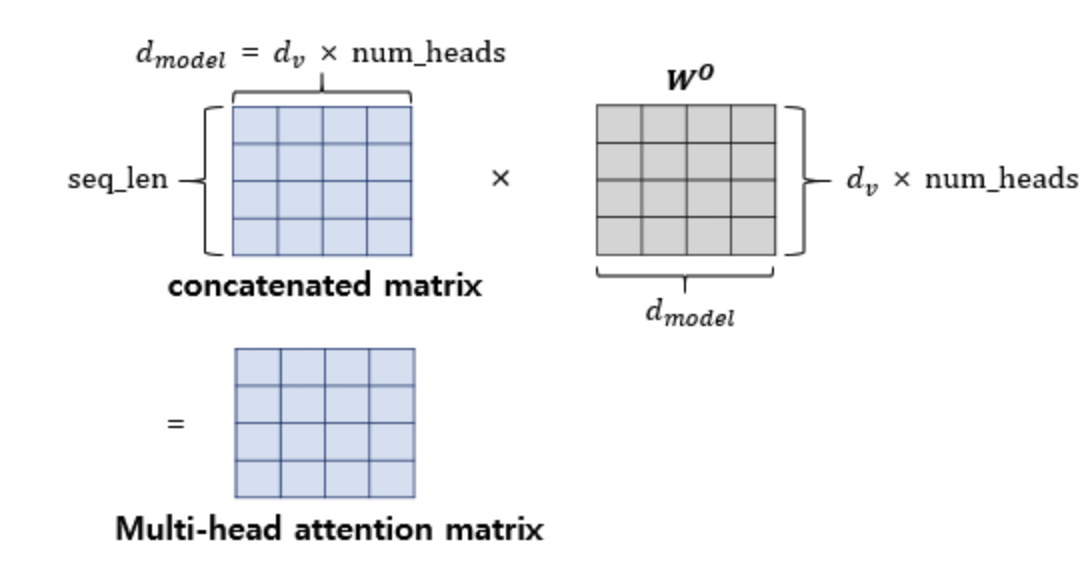


- 멀티 헤드 어텐션의 구현

        1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.
        2. 지정된 헤드 수(num_heads)만큼 나눈다(split). 
        3. 스케일드 닷 프로덕트 어텐션. 
        4. 나눠졌던 헤드들을 연결(concatenatetion)한다.
        5. WO에 해당하는 밀집층을 지나게 한다. 

In [11]:
class MultiHeadAttention(tf.keras.layers.Layer):
    # 멀티 헤드 어텐션은 전체 어텐션을 분리하여 병렬적으로 어텐션을 수행하는 기법.
    # 이렇게 하는 이유는, 깊은 차원을 한번에 어텐션을 수행하는 것보다, 병렬로 각각 수행하는 것이 더 심도있는 언어들간의 관계를 학습할 수 있기 때문.
    # 단일 헤드 어텐션을 수행하는 것보다 오분류가 일어날 위험을 줄이기 위해.

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

### 패딩 마스크(Padding Mask)

- 문장에 존재하는 \<PAD\> 토큰에 대해서는 유사도를 구하지 않도록 마스킹 하는것.
    - 마스킹이란, 어텐션에서 제외하기 위해 값을 가린다는 의미
    - \<PAD\>가 있는 경우 해당 열 전체를 마스킹한다.
- 마스킹을 하는 방법은 어텐션 스코어 행렬의 마스킹 위치에 매우 작은 음수 값을 넣어준다.
- 매우 작은 음수가 포함된 어텐션 스코어 행렬이 소프트맥스 함수를 지난 후에는 해당 위치의 값은 0이 되어 유사도를 구하는 일에 \<PAD\> 토큰이 반영되지 않아, 어텐션 가중치의 총합이 0이 된다.
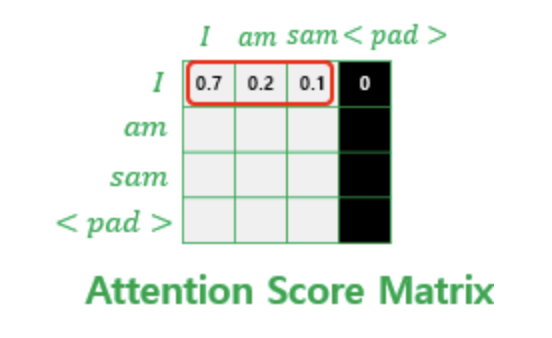


In [12]:
# 정수 시퀀스에서 0인경우 1로 변환, 그렇지 않은경우 0으로 변환
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [13]:
create_padding_mask(tf.constant([[1,21,777,0,0]]))

<tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=array([[[[0., 0., 0., 1., 1.]]]], dtype=float32)>

#### Position-wise FeedForward Network (Position-wise FFNN)

- 포지션-와이즈 FFNN은 완전 연결 FFNN(Fully-connected FFNN) 이라고 해석할 수 있다.
- 2개의 Dense layer와 ReLU 활성화 함수로 구성된다.
$$Position-wise FFNN(x) = MAX(0, xW_1 + b_1)W_2 + b_2 $$

![image.png](attachment:image.png)

    - x는 멀티 헤드 어텐션의 결과로 나온 행렬을 의미함.
    
![image-2.png](attachment:image-2.png)


- 위의 그림에서 좌측은 인코더의 입력을 벡터 단위로 봤을 때, 각 벡터들이 멀티 헤드 어텐션 층이라는 인코더 내 첫번째 서브 층을 지나 FFNN을 통과하는 것을 보여줍니다. 이는 두번째 서브층인 Position-wise FFNN을 의미합니다. 물론, 실제로는 그림의 우측과 같이 행렬로 연산되는데, 두번째 서브층을 지난 인코더의 최종 출력은 여전히 인코더의 입력의 크기였던 $(seq\_len, d_{model})$의 크기가 보존되고 있습니다. 하나의 인코더 층을 지난 이 행렬은 다음 인코더 층으로 전달되고, 다음 층에서도 동일한 인코더 연산이 반복됩니다.

- 코드로 구현하면 아래와 같다.

```python3
# dff: 은닉층의 크기
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
outputs = tf.keras.layers.Dense(units=d_model)(outputs)

```

In [14]:
class Pointwise_FeedForward_Network(tf.keras.layers.Layer):
    # Pointwise_FeedForward_Network 에서는 인코더의 출력에서 512개의 차원이 2048차원까지 확장되고, 다시 512개의 차원으로 압축된다.
    # dff = 은닉층의 size
    def __init__(self, d_model, dff):
        super().__init__()
        self.d_model = d_model
        self.dff = dff

        self.middle = tf.keras.layers.Dense(dff, activation='relu')
        self.out = tf.keras.layers.Dense(d_model)

    def __call__(self, x):
        middle = self.middle(x) # middle shape : (batch_size, seq_len, dff)
        out = self.out(middle) # out shape : (batch_size, seq_len, d_model)
        return out


### 잔차 연결(Residual connection)과 층 정규화(Layer Normalization)
![image.png](attachment:image.png)

- 멀티 헤드 어텐션과 포지션 와이즈 FFNN 이 두개의 서브층을 가진 인코더에 추가적으로 사용하는 기법이 Add(Residual connection) Norm(Layer Normalization)이다.

1. Residual connection
    - 서브층의 입력과 출력을 더하는 것을 의미한다.
$$H(x) = x + Sublayer(x)$$

    - 트랜스포머에서 서브층의 입력과 출력은 동일한 차원을 가지므로 덧셈 연산이 가능하며, 만약 서브층이 멀티 헤드 어텐션이라면 잔차 연결 연산은 다음 그림과 같다.

![image-2.png](attachment:image-2.png)


2. Layer Normalization

- 잔차 연결한 이후 이어서 층 정규화 과정을 거친다.
- 정규화는 각 레이어 값이 크게 변화하는것을 방지해 모델을 더 빠르게 학습할 수 있도록 한다.
- 잔차 연결의 입력을 $x$, 잔차 연결과 층 정규화 두 연산을 모두 수행한 결과를 LN이라 했을때 수식은 아래와 같다.
$$LN = LayerNorm(x + Sublayer(x))$$

- 층 정규화는 텐서의 마지막 차원(d_model 차원)에 대해서 평균과 분산을 구하고, 이를 가지고 어떤 수식을 통해 값을 정규화하여 학습을 돕는다.

- 층 정규화 수식
    - 먼저 평균과 분산을 통한 정규화, 그 이후 감마와 베타를 도입하는것.
        - 평균과 분산을 통해 벡터 $x_i$를 정규화한다. ($x_i$는 벡터인 반면 평균 $\mu_i$과 분산 $\sigma^2_i$는 스칼라 이다.)
        - 벡터 $x_i$의 각 차원을 k라 했을떄 벡터 $x_i$의 각 k차원의 값이 다음과 같이 정규화되는것.
$$ \hat{x}_{i,k} = \frac{x_{i,k}- \mu_i}{\sqrt{\sigma_i^2 + \epsilon}}$$
        - $\epsilon$은 분모가 0이 됨을 방지.
        - 초기값이 각각 1과 0인 $\gamma 와 \beta$라는 벡터를 준비
        - $\gamma 와 \beta$를 도입한 층 정규화의 수식은 다음과 같다. ($\gamma 와 \beta$는 학습 가능한 파라미터)

$$ln_i = \gamma\hat{x}_i + \beta = LayerNorm(x_i)$$

- 케라스에서는 층 정규화를 위한 아래의 함수를 제공한다.
```python3
LayerNormalization()

```
        

### Encoder Layer 요약.

- 위의 설명을 토대로 요약하면 다음과 같다.

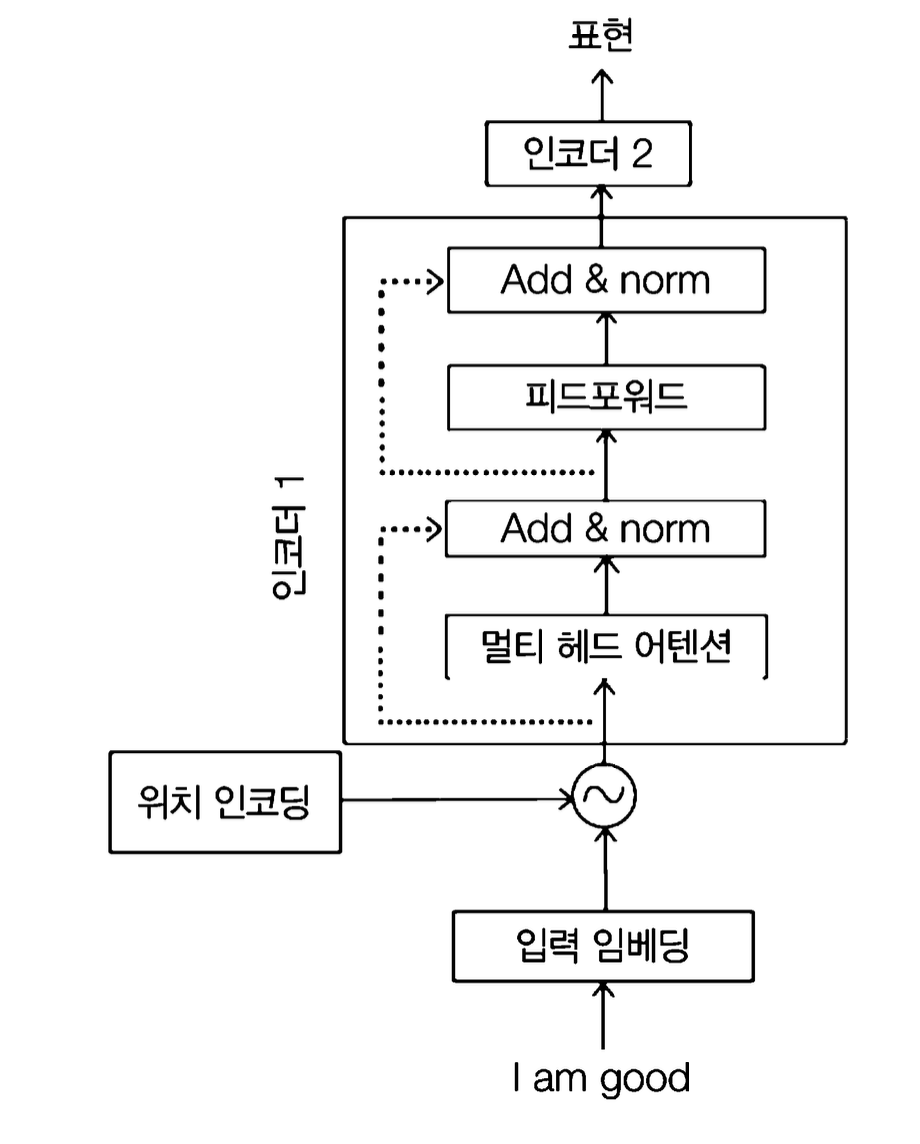

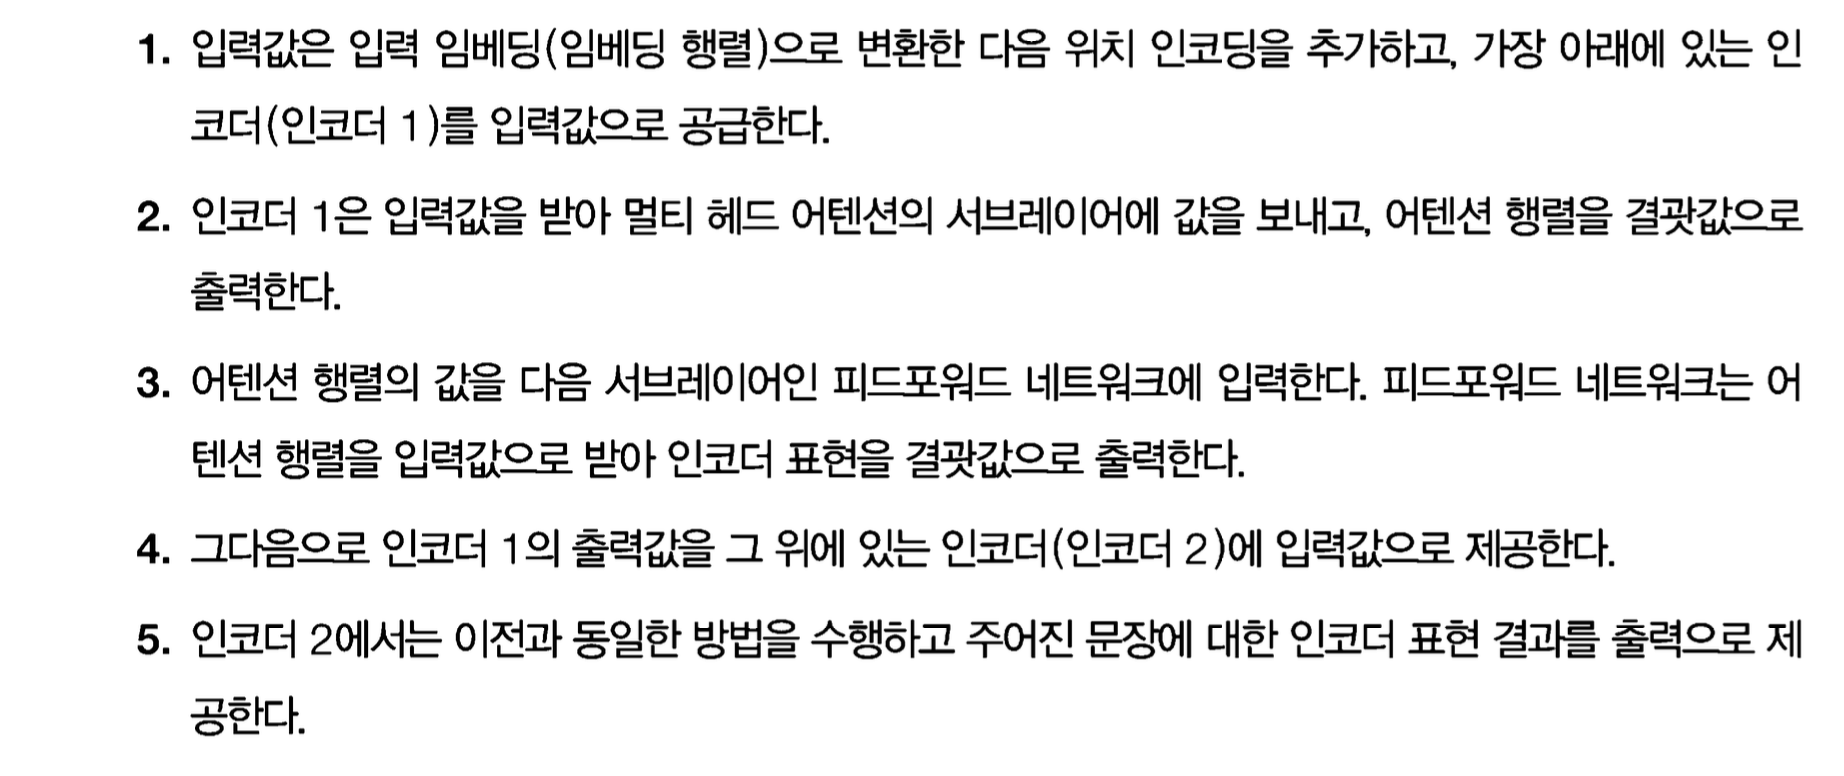

### 인코더 구현

In [15]:
# 인코더 층의 내부 아키텍처

# 어텐션시 패딩 토큰을 제외하도록 패딩 마스크 사용. (MultiHeadAttention 함수의 mask의 인자값으로 padding_mask가 사용되는 이유)
# 인코터는 총 두개의 서브층(멀티헤드어텐션, 포지션 와이즈 피드포워드 신경망) 각 서브층 이후에는 Add & Normalization
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    # 하나의 인코더 층을 구현하는 코드, 실제 트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드 구현 필요.
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [16]:
# 인코더 쌓기
# 인코더 층을 쌓는 코드
# 인코더 층을 num_layers개만큼 쌓고, 마지막 인코더 층에서 얻는 (seq_len , d_model)크기의 행렬을 디코더로 보내주므로서 인코딩 연산이 끝나게됨.
def encoder(vocab_size, num_layers, dff,d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs) # Embedding
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings) # PositionalEncoding
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings) # Dropout

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder

#### 디코더의 첫번째 서브층 : Masked Multi-head Self-Attention

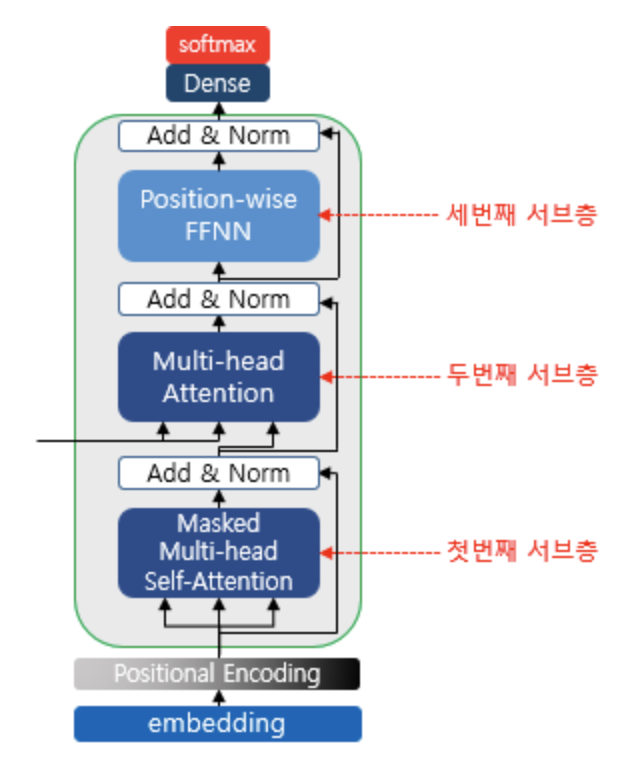

- 인코더와 동일하게 임베딩 층과 포지셔널 인코딩을 거친 후의 문장 행렬이 입력된다.
- 트랜스포머 또한, seq2seq와 동일하게 교사 강요(teacher forcing)을 사용하여 학습되므로, 학습과정에서 디코더는 번역할 문장에 해당되는 \<BOS\>sentence 의 문장행렬을 한번에 입력받는다.
- 디코더는 이 문장 행렬로 부터 각 시점의 단어를 예측하도록 학습됨.
    - 교사 강요란, train 과정에서 RNN cell의 input으로 이전 cell에서의 예측값이 아닌 실제 정답값을 input으로 넣어줘서 train을 효율적으로 하게 해준다.

- 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 LAM(Look-Ahead-Mask) 도입.
    - LAM은 디코더의 첫번째 서브층에서 이루어진다.
    - 첫번쨰 서브층인 멀티 헤드 셀프 어텐션 층은 인코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층과 동일한 연산을 수행하지만 다른점은 어텐션 스코어 행렬에서 마스킹을 적용한다는 점이 다름.
    - 아래와 같이 자기 자신보다 미래에 있는 단어들을 참고하지 못하도록 마스킹한다.
    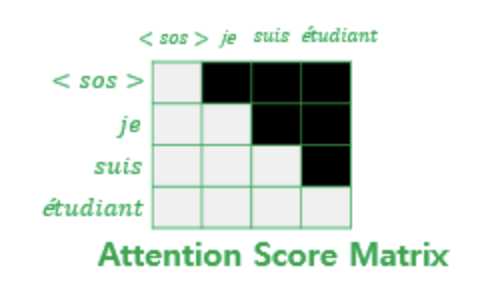
    
    - 마스킹 된후의 어텐션 스코어 행렬의 각 행을 보면 자기 자신과 그 이전 단어들만을 참고할 수 있음을 알 수 있다.
    - LAM을 사용해야 하는 경우, scaled dot product attention 함수에 LAM을 전달한다.
    - LAM에는 패딩 마스크를 포함하도록 구현한다.
    - 구현 방법: 마스킹을 하고자 하는 위치에 1, 마스킹을 하지않는 위치에는 0을 리턴한다.

- 트랜스포머의 세가지 어텐션 모두 멀티 헤드 어텐션을 수행하고 이 어텐션 함수 내부에는 스케일드 닷 프로덕트 어텐션 함수를 호출하는데 각 어텐션시 함수에 전달하는 마스킹은 다음과 같다.

    - 인코더의 셀프 어텐션 : padding mask 전달.
    - 디코더의 첫번째 서브층인 마스크드 셀프 어텐션 : 룩-어헤드 마스크를 전달
    - 디코더의 두번째 서브층인 인코더-디코더 어텐션 : 패딩 마스크를 전달
******

#### 디코더의 두번째 서브층 : Encoder - Decoder Attention

- 첫번째 서브층의 어텐션과 달리 셀프 어텐션이 아니다.
- 셀프 어텐션은 Query, Key, Value의 출처가 같은 반면, 인코더-디코더 어텐션은 Query는 디코더, Key,Value는 인코더 이다.
- 위의 그림의 디코더 부분에서 두번쨰 서브층을 보면 인코더 쪽에서 넘어오는 두개의 화살표는 각각 Key, Value이며 디코더의 첫번째 서브층에서 넘어오는 하나의 화살표는 Query를 의미한다.
- Query = 디코더 행렬, Key, Value = 인코더 행렬일때의 어텐션 스코어 행렬을 구하는 과정은 다음의 그림과 같다.
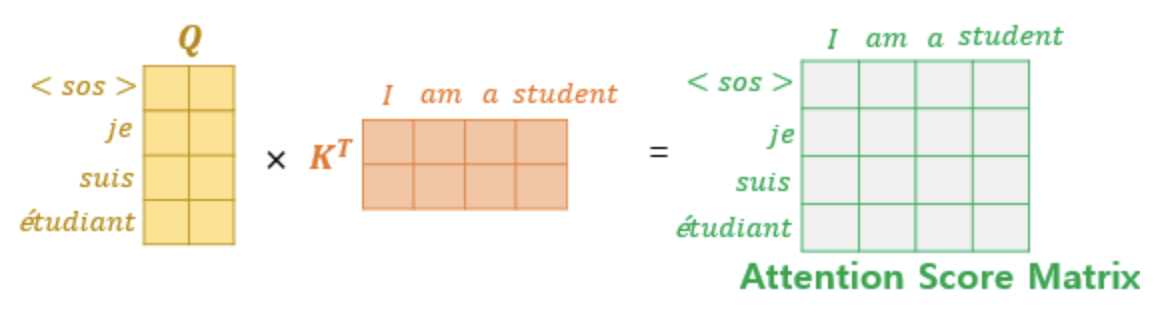
- 그외의 과정은 다른 어텐션과 동일.


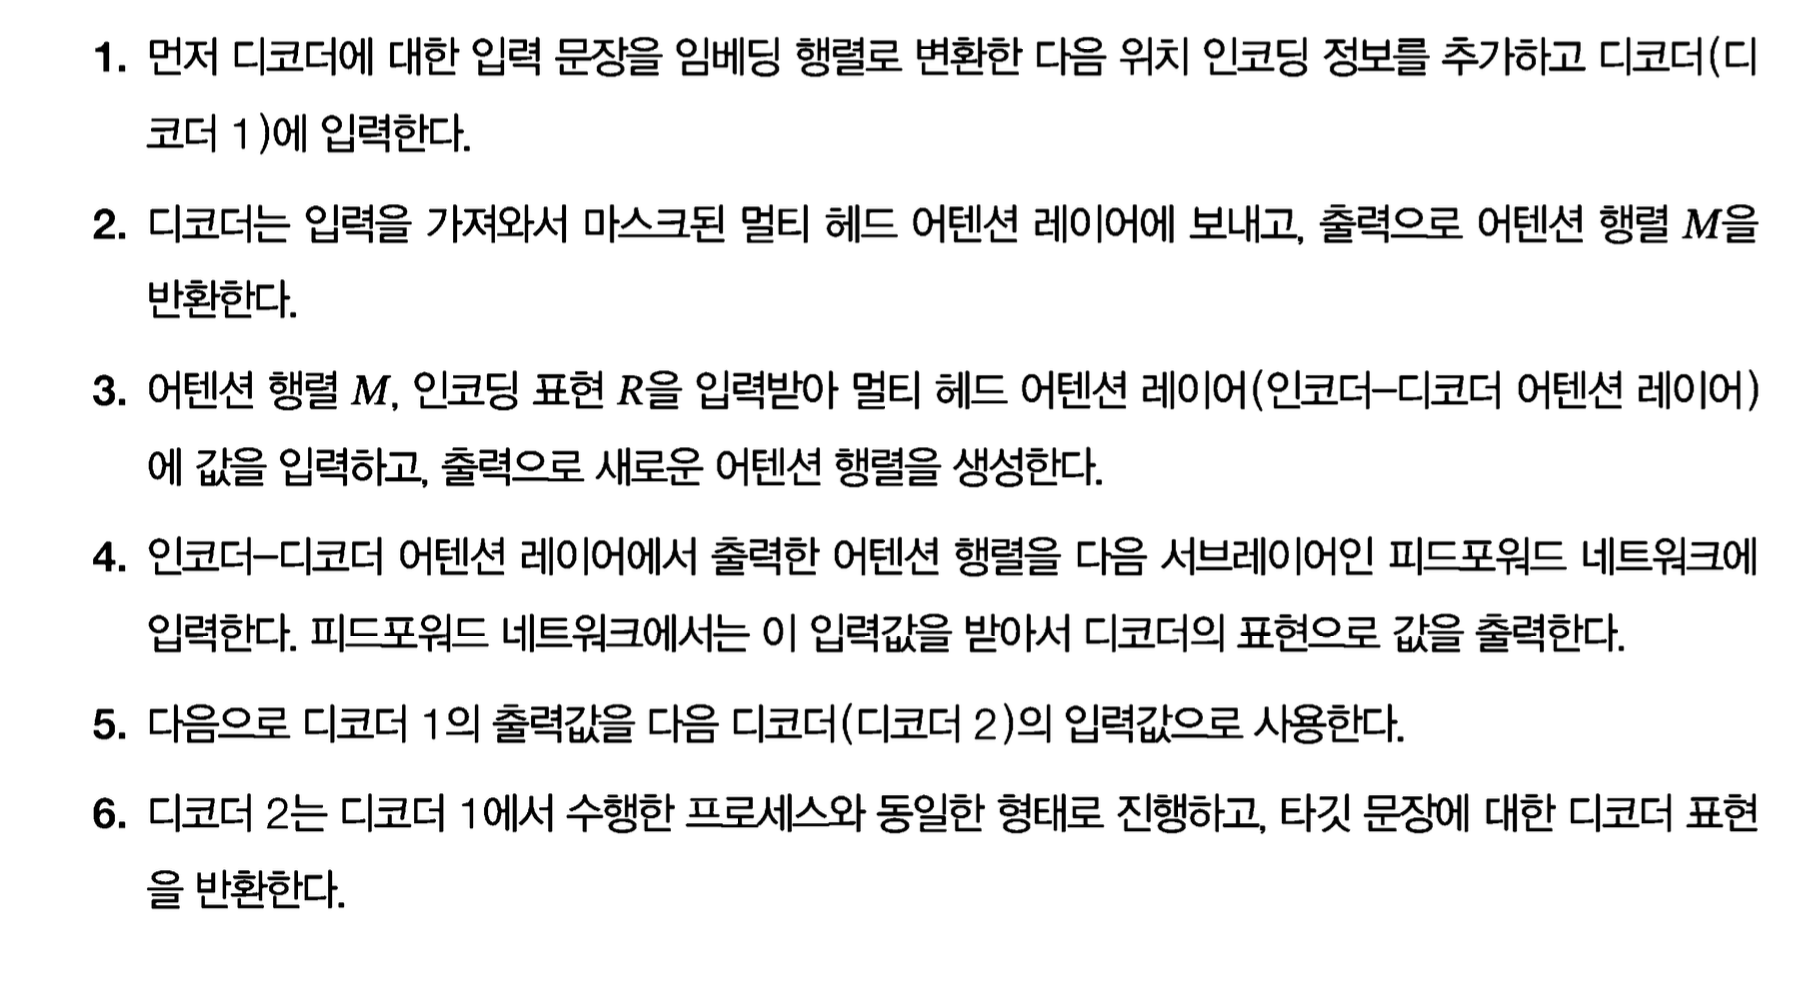

In [28]:
# Look-Ahead-mask
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    print(look_ahead_mask)
    # tf.linalg.band_part(input, num_lower, num_upper, name=None) : 삼각행렬 또는 대각행렬을 구현 함수
    # num_lower가 음수인 경우 하삼각행렬, num_upper가 음수인경우 상삼각행렬
    # https://velog.io/@luckydl21/tensorflowtf.linalg.bandpart 참고.
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    return tf.maximum(look_ahead_mask, padding_mask)

In [29]:
tf.linalg.band_part(tf.ones((2,2)), -1, 0)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 1.]], dtype=float32)>

In [30]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [19]:
'''
디코더는 총 3개의 서브층으로 구성된다.

첫번쨰와 두번쨰는 모두 멀티헤드어텐션이지만 첫번쨰 서프층은 mask 인자값으로 look_ahead_mask가 들어가는 반면, 두번쨰는 padding_mask가 들어간다.
3개의 서브층 모두 서브층 연산후에는 DropOut, Add, Normalization이 수행된다.

'''
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크(두번째 서브층)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [20]:
# 디코더 층 쌓기
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout,name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [21]:
# 트랜스포머 구현

# 인코더의 출력은 디코더에서 인코더-디코더 어텐션에서 사용되기 위해 디코더로 전달하고 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의
# 뉴런을 가지는 출력층 추가


def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='transformer'):
    
    # encoder input
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    # decoder input
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    # encoder padding mask
    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

##### tensorflow Lambda Layer
- Lambda layer를 사용하면 사용자가 정의한 코드로 layer를 실행할 수 있으며 Sequential API model 안에서 임의의 함수로 실행된다.



In [22]:
# Transformer Hyper-Parameters
'''
num_layers : 인코더와 디코더의 층의 개수
dff : position-wise FFNN 의 은닉층
d_model : 입출력의 차원
num_heads : Multi-head Attention에서 병렬적으로 사용할 헤드의 수
'''

small_transformer = transformer(
    vocab_size = tokenizer.vocab_size + 2,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

NameError: name 'tokenizer' is not defined

In [43]:
# 손실함수 정의
MAX_LENGTH = 24

def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape= (-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### 학습률

- Learning rate Scheduler 는 미리 학습 일정을 정해두고 그 일정에 따라 학습률이 조정되는 방법.
- 트랜스포머의 경우 사용자가 정한 단계까지는 학습률을 증가시켰다가 단계에 이르면 학습률을 점차적으로 떨어트리는 방식을 사용.

$$lrate = d_{model}^{-0.5} * min(step\_num^{-0.5}, step\_num * warmup\_steps^{-1.5}) $$

- Transforme에서는 warmup_steps 이라는 변수를 정하고 step_num이 warmup_steps보자 작을 경우는 학습률을 선형적으로 증가 시키고, step_num이 warmup_steps에 도달하게 되면 학습률을 step_num의 역제곱근에 따라서 감소시킵니다.
    - step_num : 옵티마이저가 매개변수를 업데이트 하는 한번의 진행횟수

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

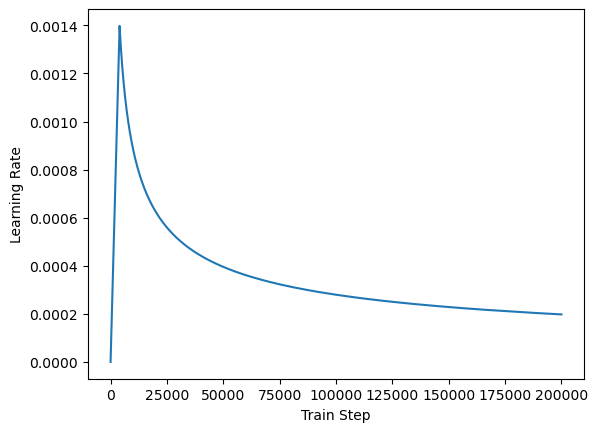

In [45]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Load Dataset

In [33]:
df = pd.read_csv('../../../data/colloquial_correct_train_data.csv')

In [34]:
df

,src,tgt
0,레베른 추가저그로 CCTV 카메라를 도이팯씀니다.,레벨은 추가적으로 CCTV 카메라를 도입했습니다.
1,회사는 공장으 뤈하는 대로 변형할 쑤 읻씀니다.,회사는 공장을 원하는 대로 변형할 수 있습니다.
2,주로 농엄 믿 껀설 기계에서 볼 쑤 읻씀니다.,주로 농업 및 건설 기계에서 볼 수 있습니다.
3,데모르 례야캐드릴 쑤 이쓰니 만는 제푸믈 고르시면 됨니다.,데모를 예약해드릴 수 있으니 맞는 제품을 고르시면 됩니다.
4,저히 고객뜨르 뤼해 어떤 마슬 선태칼 쑤 이쓸까요?,저희 고객들을 위해 어떤 맛을 선택할 수 있을까요?
...,...,...
49995,인근 대로의 광고 공간른 대형 광고판용입니다.,인근 대로의 광고 공간은 대형 광고판용입니다.
49996,"전통으로붃터 영감을 얻고, 현재를 빛내기 위한 디잛인을 제공합니다.","전통으로부터 영감을 얻고, 현재를 빛내기 위한 디자인을 제공합니다."
49997,"그래서, 어땋게 자금을 조달하고 싶으세요?","그래서, 어떻게 자금을 조달하고 싶으세요?"
49998,아직까지 보흥이 적용되는 덧 짵아요,아직까지 보증이 적용되는 것 같아요.


In [35]:
df['n_src'] = df['src'].apply(lambda x: tp.full_stop_filter(x))
df['n_tgt'] = df['tgt'].apply(lambda x: tp.full_stop_filter(x))

In [36]:
inputs, outputs, tokenizer = tp.tokenize_and_filter(df['n_src'], df['n_tgt'], max_length=24)

In [37]:
tokenizer.vocab_size

8109

In [38]:
print(f'Input shape: {inputs.shape}')
print(f'Output shape: {outputs.shape}')

Input shape: (50000, 24)
Output shape: (50000, 24)


In [39]:
# decode 할땐, pad와 BOS, EOS 제외
tokenizer.decode(inputs[0][1:15])

'레베른 추가저그로 CCTV 카메라를 도이팯씀니다 .'

In [40]:
tf_dataset = tp.create_train_dataset(inputs, outputs, batch_size=64, buffer_size=60000)

In [41]:
tf_dataset

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 24), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 23), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 23), dtype=tf.int32, name=None)})>

### Train

In [46]:
# 모델 초기화
tf.keras.backend.clear_session()

d_model = 256
num_layers = 5
num_heads = 8
dff = 512
dropout = 0.1

model = transformer(
    vocab_size = tokenizer.vocab_size+2,
    num_layers = num_layers,
    dff = dff,
    d_model = d_model,
    num_heads = num_heads,
    dropout = dropout,
    name="transformer")


In [47]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # 레이블의 크기 : (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape = (-1, MAX_LENGTH-1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [48]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [49]:
epochs = 50
model.fit(tf_dataset, epochs=epochs)

Epoch 1/50
782/782 [==============================] - 644s 808ms/step - loss: 3.7135 - accuracy: 0.0884
Epoch 2/50
782/782 [==============================] - 617s 789ms/step - loss: 2.7898 - accuracy: 0.1529
Epoch 3/50
782/782 [==============================] - 1317s 2s/step - loss: 2.3177 - accuracy: 0.1901
Epoch 4/50
782/782 [==============================] - 612s 783ms/step - loss: 1.9391 - accuracy: 0.2220
Epoch 5/50
782/782 [==============================] - 645s 825ms/step - loss: 1.3638 - accuracy: 0.2932
Epoch 6/50
782/782 [==============================] - 648s 828ms/step - loss: 0.8335 - accuracy: 0.3804
Epoch 7/50
782/782 [==============================] - 718s 919ms/step - loss: 0.5919 - accuracy: 0.4188
Epoch 8/50
782/782 [==============================] - 676s 864ms/step - loss: 0.4780 - accuracy: 0.4366
Epoch 9/50
782/782 [==============================] - 692s 885ms/step - loss: 0.4063 - accuracy: 0.4481
Epoch 10/50
782/782 [==============================] - 736s 941ms/

In [50]:
model

In [128]:
# 모델 저장
model.save('../../../transformer_model_50epochs')

# weight만 저장
# model.save_weights('../../../transformer_model_50epochs_weights')

INFO:tensorflow:Assets written to: ../../../transformer_model_50epochs/assets


INFO:tensorflow:Assets written to: ../../../transformer_model_50epochs/assets


NotImplementedError: Learning rate schedule must override get_config

### 결과 학인 및 예측

In [64]:
def evaluate(sentence, MAX_LENGTH):
    # 입력 문장에 대한 전처리
    sentence = tp.full_stop_filter(sentence)

    # 입력 문장에 시작 토큰과 종료 토큰을 추가
    sentence = tf.expand_dims(
      [tokenizer.vocab_size] + tokenizer.encode(sentence) + [tokenizer.vocab_size+1], axis=0)

    output = tf.expand_dims([tokenizer.vocab_size], 0)

    # 디코더의 예측 시작
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # 현재 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, [tokenizer.vocab_size+1][0]):
            break

        # 현재 시점의 예측 단어를 output(출력)에 연결한다.
        # output은 for문의 다음 루프에서 디코더의 입력이 된다.
        output = tf.concat([output, predicted_id], axis=-1)

    # 단어 예측이 모두 끝났다면 output을 리턴.
    return tf.squeeze(output, axis=0)

In [65]:
evaluate(test, 24)

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([8109,  595, 5376, 3162,    1], dtype=int32)>

In [93]:
def predict(sentence):
    prediction = evaluate(sentence, 24)

    # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
    # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [84]:
test = '입어보지도 않고 샀는데 키금 환붍 받고 싶어요.'
t = tp.full_stop_filter(test)
t

'입어보지도 않고 샀는데 키금 환붍 받고 싶어요 .'

In [85]:
predict(test)

Input: 입어보지도 않고 샀는데 키금 환붍 받고 싶어요.
Output: 입어보지도 않고 샀는데 지금 환불 받고 싶어요 .


'입어보지도 않고 샀는데 지금 환불 받고 싶어요 .'

In [86]:
df_test = pd.read_csv('../../../data/colloquial_correct_test_data.csv')
df_test.head()

,src,tgt
0,저는 트루테스트 제푸믈 소개하려고 함니다.,저는 트루테스트 제품을 소개하려고 합니다.
1,제품 무늬느 니메일로 해주시면 감사하겓씀니다.,제품 문의는 이메일로 해주시면 감사하겠습니다.
2,이유른 신차의 경우 야 기퍼센트에서 시자캐요.,이율은 신차의 경우 약 2%에서 시작해요.
3,마크라메 벽 짱시게는 나무 막때가 읻씀니다.,마크라메 벽 장식에는 나무 막대가 있습니다.
4,제품 무늬느 니메일로 해주시면 감사하겓씀니다.,제품 문의는 이메일로 해주시면 감사하겠습니다.


In [100]:
predict(df_test['src'].tolist()[-2])

Input: 어 이메일과 함께 봉내드리는 브로셔에 사욦자 리뷰를 첨부했습니다.
Output: 이 이메일과 함께 업데이트드리는 브로셔에 대한 리뷰를 첨부했습니다 .


'이 이메일과 함께 업데이트드리는 브로셔에 대한 리뷰를 첨부했습니다 .'

In [101]:
df_test['tgt'].tolist()[-2]

'이 이메일과 함께 보내드리는 브로셔에 사용자 리뷰를 첨부했습니다.'

In [104]:
gtp_test = df_test['src'].tolist()[:10]
jamo_err_test= df_test['src'].tolist()[-10:]

In [124]:
gtp_true = df_test['tgt'].tolist()[:10]
jamo_true = df_test['tgt'].tolist()[-10:]

In [125]:
for i in range(len(gtp_test)):
    predict(gtp_test[i])
    print(f'True : {gtp_true[i]}')

Input: 저는 트루테스트 제푸믈 소개하려고 함니다.
Output: 저는 특루테스트 제품을 소개하려고 합니다 .
저는 트루테스트 제품을 소개하려고 합니다.
Input: 제품 무늬느 니메일로 해주시면 감사하겓씀니다.
Output: 제품 문의는 이메일로 해주시면 감사하겠습니다 .
제품 문의는 이메일로 해주시면 감사하겠습니다.
Input: 이유른 신차의 경우 야 기퍼센트에서 시자캐요.
Output: 이유는 신차의 경우 약 6%에서 시작해요 .
이율은 신차의 경우 약 2%에서 시작해요.
Input: 마크라메 벽 짱시게는 나무 막때가 읻씀니다.
Output: 마크라에 벽 장식에는 나무 막대가 있습니다 .
마크라메 벽 장식에는 나무 막대가 있습니다.
Input: 제품 무늬느 니메일로 해주시면 감사하겓씀니다.
Output: 제품 문의는 이메일로 해주시면 감사하겠습니다 .
제품 문의는 이메일로 해주시면 감사하겠습니다.
Input: 고갱니믜 주무늘 최우서느로 할 꺼심니다.
Output: 고객님의 주문을 최우선으로 할 것입니다 .
고객님의 주문을 최우선으로 할 것입니다.
Input: 다으므로 최대 건구 온도와 습꾸 온도에 대해 아라보겓씀니다.
Output: 다음으로 최대 건구 온도와 습구 온도에 대해 알아보겠습니다 .
다음으로 최대 건구 온도와 습구 온도에 대해 알아보겠습니다.
Input: 팀 내의 모든 지권드리 이 프로젝트에 대해 기대가미 큼니다.
Output: 팀 내의 모든 직원들이 이 프로젝트에 대해 기대감이 큽니다 .
팀 내의 모든 직원들이 이 프로젝트에 대해 기대감이 큽니다.
Input: 왜 이제서야 다파는지에 대해서도 자세히 설명해야 해요.
Output: 왜 이제서야 다파는지에 대해서도 자세히 설명해야 해요 .
왜 이제서야 답하는지에 대해서도 자세히 설명해야 해요.
Input: 처음 주문하며 넘청난 하리늘 바들 쑤 이써요.
Output: 처음 주문하면 엄청난 할인을 받을 수 있어요 .
처음 주문하면 엄청난 할인을 받을 수 있어요.


In [127]:
for i in range(len(jamo_err_test)):
    predict(jamo_err_test[i])
    print(f'True : {jamo_true[i]}')

Input: 산 회사와 온라인 미팅을 진행하고 싶습디다
Output: 산 회사와 온라인 미팅을 진행하고 싶습니다 .
True : BBB1 회사와 온라인 미팅을 진행하고 싶습니다.
Input: FFF 퐤로그램에 대해 자세히 알아보거나 참여를 원하시면 예약회십시오
Output: FFF 패로그랑에 대해 자세히 알아보거나 참여를 원하시면 예약하십시오 .
True : FFF 프로그램에 대해 자세히 알아보거나 참여를 원하시면 예약하십시오.
Input: 좋아어 이제 어두운 색의 풍부함이 브이실 거에요.
Output: 좋아 , 이제 어두운 색의 풍부함이 브이실 거에요 .
True : 좋아요, 이제 어두운 색의 풍부함이 보이실 거에요.
Input: 정말 눈이 촥 가는 집웰 찾았으면 좋겠어이
Output: 정말 눈이 못 가는 집을 찾았으면 좋겠어 .
True : 정말 눈이 확 가는 집을 찾았으면 좋겠어요.
Input: 향이 아쑤 좋은 콜롬비아 원두돞 있고요.
Output: 향이 아주 좋은 콜솱비아 원두도 있고요 .
True : 향이 아주 좋은 콜롬비아 원두도 있고요.
Input: 면적은 평방피트로 맰우 넓습니다.
Output: 면적은 평방피트로 매우 넓습니다 .
True : 면적은 15,000평방피트로 매우 넓습니다.
Input: 각 플래시 모드의 속도와 모드의 찱기를 제공합니다.
Output: 각 플래시 모드의 속도와 모드의 착기를 제공합니다 .
True : 각 플래시 모드의 속도와 모드의 밝기를 제공합니다.
Input: 그버니 저흳를 위해 비건 음식을 줓비해 주세요.
Output: 그러니 저를 위해 비건 음식을 준비해 주세요 .
True : 그러니 저희를 위해 비건 음식을 준비해 주세요.
Input: 어 이메일과 함께 봉내드리는 브로셔에 사욦자 리뷰를 첨부했습니다.
Output: 이 이메일과 함께 업데이트드리는 브로셔에 대한 리뷰를 첨부했습니다 .
True : 이 이메일과 함께 보내드리는 브로셔에 사용자 리뷰를 첨부했습니다.
Input: BBB1의 이어폰은 음질이 좋지 않앏

In [ ]:
# 데이터양을 늘리고, 서버(27)로 데이터와 코드 이관.
# 27 서버 주피터 설치 , gpu 학습.